**Гиперпараметры (Hyperparameters)** — параметры модели, которые задаются **до обучения** и не меняются в процессе. Примеры: C и gamma в SVM, max_depth и learning_rate в XGBoost, количество нейронов в слое. Отличие от параметров: параметры (веса) обучаются из данных, гиперпараметры задаются вручную или подбираются.

**Гипертюнинг (Hyperparameter Tuning)** — процесс поиска оптимальных гиперпараметров. Цель: максимизировать метрику качества (accuracy, ROC-AUC) на валидации.

**Кросс-валидация (Cross-Validation, CV)** — техника оценки модели, где данные разбиваются на K фолдов (частей). Модель обучается K раз: каждый раз на (K-1) фолдах, валидируется на оставшемся. Итоговая метрика = среднее по K фолдам. Преимущество: использует все данные для обучения И валидации, снижает variance оценки.

**K-Fold CV** — стандартная кросс-валидация. Данные делятся на K равных частей случайно. Обычно K=5 или K=10.

**Stratified K-Fold** — кросс-валидация с сохранением пропорций классов в каждом фолде. Критично для дисбаланса классов.

**Leave-One-Out CV (LOO)** — крайний случай K-Fold, где K = n (количество объектов). Каждый объект по очереди — валидация, остальные — обучение. Очень точная оценка, но **медленная**.

**Time Series Split** — кросс-валидация для временных рядов. Фолды идут последовательно (train: 1-100, val: 101-200; train: 1-200, val: 201-300). Предотвращает "заглядывание в будущее".

**GridSearchCV** — exhaustive search (полный перебор) всех комбинаций гиперпараметров из заданной сетки. Пример: C=[0.1, 1, 10], gamma=[0.001, 0.01] → 3×2=6 комбинаций. Для каждой комбинации запускается K-fold CV. Выбирается комбинация с лучшей средней метрикой.

**RandomizedSearchCV** — случайный поиск. Вместо перебора всех комбинаций, сэмплирует N случайных комбинаций из распределений параметров. Преимущество: быстрее GridSearch (особенно при >5 параметрах), может найти неочевидные комбинации.

**Search Space (пространство поиска)** — набор всех возможных комбинаций гиперпараметров. Размер = произведение количеств значений каждого параметра.

**Best Estimator** — модель с лучшими найденными параметрами, переобученная на **всём train set**.

**Overfitting в гипертюнинге** — ситуация, когда параметры оптимизированы под конкретные фолды CV, но не обобщаются на test. Решение: nested cross-validation или отдельный hold-out test set.

**Learning Curve** — график зависимости метрики от размера обучающей выборки. Показывает две кривые: train score и validation score. Используется для диагностики: underfitting (обе кривые низко), overfitting (train высоко, val низко), нужно больше данных (val растёт, но не стабилизировалась).

**Validation Curve** — график зависимости метрики от значения гиперпараметра. Показывает, как train/val меняются при изменении одного параметра (например, C в SVM).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV, 
                                      cross_val_score, StratifiedKFold,
                                      train_test_split, learning_curve, validation_curve)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

from scipy.stats import uniform, randint
import time

sns.set_theme(style="whitegrid", palette="Set2", font_scale=1.1)

# Загрузка Stroke Prediction Dataset
df = pd.read_csv('https://github.com/Dikovitsky-Vladimir/Edu/raw/refs/heads/main/healthcare-dataset-stroke-data.csv')

print(f"Датасет Stroke Prediction: {df.shape[0]} строк × {df.shape[1]} столбцов")
print(f"\nЦелевая переменная: stroke")
print(f"  0 = no stroke (нет инсульта)")
print(f"  1 = stroke (инсульт)")

Датасет Stroke Prediction: 5110 строк × 12 столбцов

Целевая переменная: stroke
  0 = no stroke (нет инсульта)
  1 = stroke (инсульт)


In [2]:
df.head(10)
df.info()

print("\n=== ОПИСАНИЕ ПРИЗНАКОВ ===")
feature_desc = {
    'id': 'Идентификатор пациента',
    'gender': 'Пол (Male/Female/Other)',
    'age': 'Возраст',
    'hypertension': 'Гипертония (0=нет, 1=да)',
    'heart_disease': 'Болезнь сердца (0=нет, 1=да)',
    'ever_married': 'Был ли в браке (Yes/No)',
    'work_type': 'Тип работы (Private/Self-employed/Govt_job/children/Never_worked)',
    'Residence_type': 'Тип места жительства (Urban/Rural)',
    'avg_glucose_level': 'Средний уровень глюкозы',
    'bmi': 'Индекс массы тела',
    'smoking_status': 'Статус курения (formerly smoked/never smoked/smokes/Unknown)',
    'stroke': 'Инсульт (0=нет, 1=да) [ЦЕЛЕВАЯ]'
}

for col, desc in feature_desc.items():
    marker = "🎯" if col == 'stroke' else "📊"
    print(f"{marker} {col:20s}: {desc}")

# ПРОБЛЕМА 1: Дисбаланс классов
print("\n=== ПРОБЛЕМА 1: ДИСБАЛАНС ===")
print(df['stroke'].value_counts())
print(f"Процент инсультов: {df['stroke'].mean()*100:.2f}%")
print("→ Сильный дисбаланс! ROC-AUC важнее accuracy")

# ПРОБЛЕМА 2: Пропуски
print("\n=== ПРОБЛЕМА 2: ПРОПУСКИ ===")
missing = df.isnull().sum()
print(missing[missing > 0])

# ПРОБЛЕМА 3: Категориальные признаки
print("\n=== ПРОБЛЕМА 3: КАТЕГОРИИ ===")
cat_cols = df.select_dtypes(include='object').columns.tolist()
print(f"Категориальные: {cat_cols}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB

=== ОПИСАНИЕ ПРИЗНАКОВ ===
📊 id                  : Идентификатор пациента
📊 gender              : Пол (Male/Female/Other)
📊 age                 : Возраст
📊 

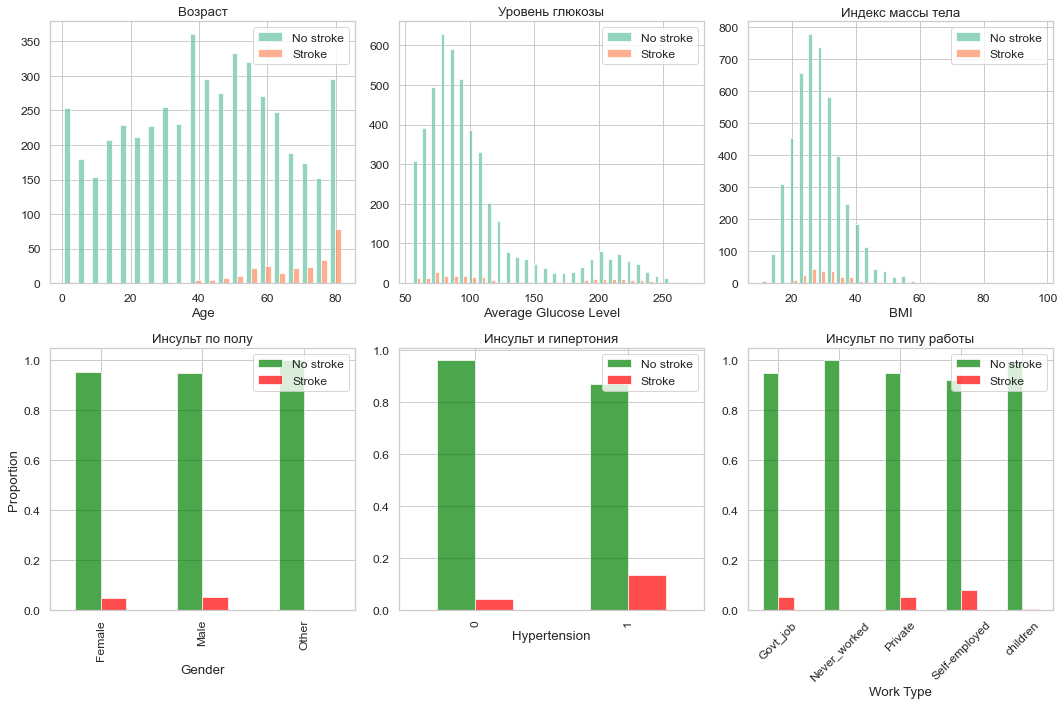

  Факторы риска инсульта:
  • Возраст (старше → выше риск)
  • Гипертония, болезни сердца
  • Высокий уровень глюкозы


In [3]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Age
axes[0, 0].hist([df[df['stroke']==0]['age'], df[df['stroke']==1]['age']], 
                bins=20, label=['No stroke', 'Stroke'], alpha=0.7)
axes[0, 0].set_xlabel('Age')
axes[0, 0].legend()
axes[0, 0].set_title('Возраст')

# Glucose level
axes[0, 1].hist([df[df['stroke']==0]['avg_glucose_level'], 
                 df[df['stroke']==1]['avg_glucose_level']], 
                bins=30, label=['No stroke', 'Stroke'], alpha=0.7)
axes[0, 1].set_xlabel('Average Glucose Level')
axes[0, 1].legend()
axes[0, 1].set_title('Уровень глюкозы')

# BMI
df_bmi = df.dropna(subset=['bmi'])
axes[0, 2].hist([df_bmi[df_bmi['stroke']==0]['bmi'], 
                 df_bmi[df_bmi['stroke']==1]['bmi']], 
                bins=30, label=['No stroke', 'Stroke'], alpha=0.7)
axes[0, 2].set_xlabel('BMI')
axes[0, 2].legend()
axes[0, 2].set_title('Индекс массы тела')

# Gender
gender_stroke = pd.crosstab(df['gender'], df['stroke'], normalize='index')
gender_stroke.plot(kind='bar', ax=axes[1, 0], color=['green', 'red'], alpha=0.7)
axes[1, 0].set_title('Инсульт по полу')
axes[1, 0].set_xlabel('Gender')
axes[1, 0].set_ylabel('Proportion')
axes[1, 0].legend(['No stroke', 'Stroke'])

# Hypertension
hyper_stroke = pd.crosstab(df['hypertension'], df['stroke'], normalize='index')
hyper_stroke.plot(kind='bar', ax=axes[1, 1], color=['green', 'red'], alpha=0.7)
axes[1, 1].set_title('Инсульт и гипертония')
axes[1, 1].set_xlabel('Hypertension')
axes[1, 1].legend(['No stroke', 'Stroke'])

# Work type
work_stroke = pd.crosstab(df['work_type'], df['stroke'], normalize='index')
work_stroke.plot(kind='bar', ax=axes[1, 2], color=['green', 'red'], alpha=0.7)
axes[1, 2].set_title('Инсульт по типу работы')
axes[1, 2].set_xlabel('Work Type')
axes[1, 2].legend(['No stroke', 'Stroke'])
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("  Факторы риска инсульта:")
print("  • Возраст (старше → выше риск)")
print("  • Гипертония, болезни сердца")
print("  • Высокий уровень глюкозы")

In [4]:
# Удаляем id (не нужен)
df = df.drop('id', axis=1)

# Целевая переменная
X = df.drop('stroke', axis=1)
y = df['stroke']

# Train/test split (stratify!)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train: {X_train.shape[0]} samples ({y_train.mean()*100:.2f}% strokes)")
print(f"Test:  {X_test.shape[0]} samples ({y_test.mean()*100:.2f}% strokes)")

Train: 4088 samples (4.87% strokes)
Test:  1022 samples (4.89% strokes)


In [10]:
# Определяем числовые и категориальные признаки
numeric_features = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Трансформеры для числовых признаков
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Заполняем пропуски медианой
    ('scaler', StandardScaler())                     # Масштабируем
])

# Трансформеры для категориальных признаков
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Заполняем модой
    ('onehot', OneHotEncoder( sparse=False,handle_unknown='ignore' ))  # One-hot #drop='first',
])

# Объединяем через ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Финальный Pipeline: предобработка + классификатор (placeholder)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())  # Временно, заменим в GridSearch
])

print("  Pipeline создан!")
print("   Порядок: Imputation → Encoding → Scaling → Classifier")
print("  Почему Pipeline критичен для GridSearchCV:")
print("   • Предобработка применяется ВНУТРИ каждого фолда CV")
print("   • Нет data leakage (тест не видит параметры предобработки)")
print("   • Удобно: один объект для fit/predict")

  Pipeline создан!
   Порядок: Imputation → Encoding → Scaling → Classifier
  Почему Pipeline критичен для GridSearchCV:
   • Предобработка применяется ВНУТРИ каждого фолда CV
   • Нет data leakage (тест не видит параметры предобработки)
   • Удобно: один объект для fit/predict


In [11]:
# Проверяем, что Pipeline работает
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])

print(f"Pipeline с Logistic Regression (дефолтные параметры):")
print(f"  Test Accuracy: {acc:.4f}")
print(f"  Test ROC-AUC:  {auc:.4f}")
print("\n Baseline установлен — теперь улучшим через GridSearchCV!")

Pipeline с Logistic Regression (дефолтные параметры):
  Test Accuracy: 0.9521
  Test ROC-AUC:  0.8417

 Baseline установлен — теперь улучшим через GridSearchCV!


In [12]:
# Создаём Pipeline с SVM
pipeline_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True, random_state=42))  # probability=True для ROC-AUC
])

# Сетка параметров для перебора
param_grid = {
    'classifier__C': [0.1, 1, 10, 100],              # Регуляризация
    'classifier__gamma': ['scale', 'auto', 0.001, 0.01, 0.1],  # Ширина RBF ядра
    'classifier__kernel': ['rbf', 'linear']          # Тип ядра
}

print(f"Пространство поиска:")
print(f"  C: 4 значения")
print(f"  gamma: 5 значений")
print(f"  kernel: 2 значения")
print(f"  Всего комбинаций: 4 × 5 × 2 = 40")
print(f"  С 5-fold CV: 40 × 5 = 200 обучений модели!")

# GridSearchCV
grid_search = GridSearchCV(
    pipeline_svm,
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),  # 5-fold CV
    scoring='roc_auc',          # Метрика для оптимизации
    n_jobs=-1,                  # Параллельно на всех ядрах
    verbose=2                   # Прогресс
)

print("\n Начинаем поиск (может занять 2-5 минут)...")
start_time = time.time()
grid_search.fit(X_train, y_train)
elapsed = time.time() - start_time

print(f" Поиск завершён за {elapsed:.1f} сек ({elapsed/60:.1f} мин)")

Пространство поиска:
  C: 4 значения
  gamma: 5 значений
  kernel: 2 значения
  Всего комбинаций: 4 × 5 × 2 = 40
  С 5-fold CV: 40 × 5 = 200 обучений модели!

 Начинаем поиск (может занять 2-5 минут)...
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 46.8min finished


 Поиск завершён за 2808.9 сек (46.8 мин)


In [13]:
# Лучшие параметры
print("="*80)
print("РЕЗУЛЬТАТЫ GRIDSEARCHCV")
print("="*80)

print(f"\n Лучшие параметры:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\n Лучший CV ROC-AUC: {grid_search.best_score_:.4f}")

# Тест на hold-out test set
y_pred_grid = grid_search.predict(X_test)
y_proba_grid = grid_search.predict_proba(X_test)[:, 1]

acc_grid = accuracy_score(y_test, y_pred_grid)
auc_grid = roc_auc_score(y_test, y_proba_grid)

print(f"\nTest set (hold-out):")
print(f"  Accuracy: {acc_grid:.4f}")
print(f"  ROC-AUC:  {auc_grid:.4f}")

# Сравнение с baseline
print(f"\n Улучшение vs baseline:")
print(f"  Baseline ROC-AUC: {auc:.4f}")
print(f"  GridSearch ROC-AUC: {auc_grid:.4f}")
print(f"  Прирост: {(auc_grid - auc)*100:+.1f} п.п.")

РЕЗУЛЬТАТЫ GRIDSEARCHCV

 Лучшие параметры:
  classifier__C: 100
  classifier__gamma: 0.001
  classifier__kernel: rbf

 Лучший CV ROC-AUC: 0.6916

Test set (hold-out):
  Accuracy: 0.9511
  ROC-AUC:  0.7187

 Улучшение vs baseline:
  Baseline ROC-AUC: 0.8417
  GridSearch ROC-AUC: 0.7187
  Прирост: -12.3 п.п.


Топ-10 комбинаций параметров:
                                                                            params  mean_test_score  std_test_score  rank_test_score
   {'classifier__C': 100, 'classifier__gamma': 0.001, 'classifier__kernel': 'rbf'}         0.691590        0.040616                1
    {'classifier__C': 10, 'classifier__gamma': 0.001, 'classifier__kernel': 'rbf'}         0.672727        0.050466                2
 {'classifier__C': 100, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}         0.657695        0.023649                3
     {'classifier__C': 100, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}         0.640240        0.025737                4
     {'classifier__C': 10, 'classifier__gamma': 0.01, 'classifier__kernel': 'rbf'}         0.622055        0.046021                5
      {'classifier__C': 1, 'classifier__gamma': 0.01, 'classifier__kernel': 'rbf'}         0.614419        0.056270                6
  {'classifier__C': 0.1, 'classifier__g

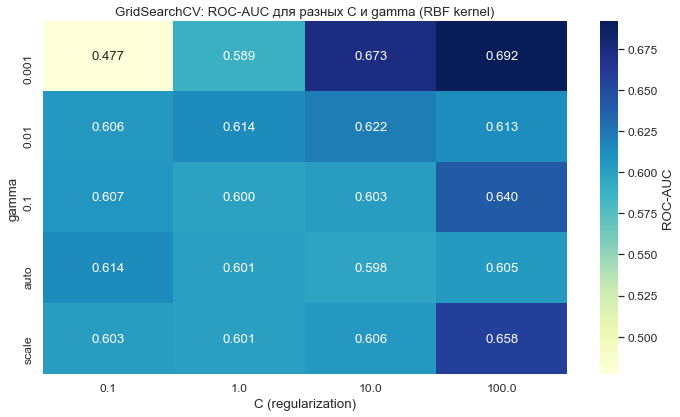


 Наблюдения:
  • Для RBF: лучшие результаты обычно при C=1-10, gamma='scale' или 0.01
  • Linear kernel иногда сопоставим с RBF (проще, быстрее)


In [14]:
# Смотрим топ-10 комбинаций
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values('rank_test_score')

print("Топ-10 комбинаций параметров:")
print(results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].head(10).to_string(index=False))

# Визуализация: heatmap для C vs gamma (rbf kernel)
rbf_results = results_df[results_df['param_classifier__kernel'] == 'rbf']
pivot = rbf_results.pivot_table(
    values='mean_test_score',
    index='param_classifier__gamma',
    columns='param_classifier__C'
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt='.3f', cmap='YlGnBu', cbar_kws={'label': 'ROC-AUC'})
plt.title('GridSearchCV: ROC-AUC для разных C и gamma (RBF kernel)')
plt.xlabel('C (regularization)')
plt.ylabel('gamma')
plt.tight_layout()
plt.show()

print("\n Наблюдения:")
print("  • Для RBF: лучшие результаты обычно при C=1-10, gamma='scale' или 0.01")
print("  • Linear kernel иногда сопоставим с RBF (проще, быстрее)")

In [15]:
# Pipeline с Gradient Boosting
pipeline_gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Распределения параметров (вместо списков значений)
param_distributions = {
    'classifier__n_estimators': randint(50, 300),           # Случайное целое 50-300
    'classifier__learning_rate': uniform(0.01, 0.29),       # Случайное float 0.01-0.3
    'classifier__max_depth': randint(3, 10),                # Глубина 3-10
    'classifier__min_samples_split': randint(2, 20),        # 2-20
    'classifier__min_samples_leaf': randint(1, 10),         # 1-10
    'classifier__subsample': uniform(0.5, 0.5)              # 0.5-1.0
}

print(f"Пространство поиска (ОГРОМНОЕ):")
print(f"  n_estimators: [50, 300] — 250 значений")
print(f"  learning_rate: [0.01, 0.3] — бесконечно много (float)")
print(f"  max_depth: [3, 10] — 7 значений")
print(f"  ... и ещё 3 параметра")
print(f"  Полный перебор НЕВОЗМОЖЕН — миллиарды комбинаций!")
print(f"\n RandomizedSearchCV сэмплирует N=50 случайных комбинаций")

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline_gb,
    param_distributions,
    n_iter=50,              # Количество случайных комбинаций
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

print("\n Начинаем случайный поиск (50 × 5 = 250 обучений)...")
start_time = time.time()
random_search.fit(X_train, y_train)
elapsed = time.time() - start_time

print(f"\n Поиск завершён за {elapsed:.1f} сек ({elapsed/60:.1f} мин)")

# Результаты
print(f"\n Лучшие параметры:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\n Лучший CV ROC-AUC: {random_search.best_score_:.4f}")

# Test
y_proba_random = random_search.predict_proba(X_test)[:, 1]
auc_random = roc_auc_score(y_test, y_proba_random)

print(f"\nTest ROC-AUC: {auc_random:.4f}")

Пространство поиска (ОГРОМНОЕ):
  n_estimators: [50, 300] — 250 значений
  learning_rate: [0.01, 0.3] — бесконечно много (float)
  max_depth: [3, 10] — 7 значений
  ... и ещё 3 параметра
  Полный перебор НЕВОЗМОЖЕН — миллиарды комбинаций!

 RandomizedSearchCV сэмплирует N=50 случайных комбинаций

 Начинаем случайный поиск (50 × 5 = 250 обучений)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   49.6s finished



 Поиск завершён за 50.2 сек (0.8 мин)

 Лучшие параметры:
  classifier__learning_rate: 0.013846838736361293
  classifier__max_depth: 3
  classifier__min_samples_leaf: 2
  classifier__min_samples_split: 10
  classifier__n_estimators: 139
  classifier__subsample: 0.5488360570031919

 Лучший CV ROC-AUC: 0.8487

Test ROC-AUC: 0.8368


In [16]:
# Финальное сравнение всех подходов
comparison = pd.DataFrame({
    'Подход': ['Baseline (LR)', 'GridSearchCV (SVM)', 'RandomizedSearch (GB)'],
    'CV ROC-AUC': ['-', f'{grid_search.best_score_:.4f}', f'{random_search.best_score_:.4f}'],
    'Test ROC-AUC': [f'{auc:.4f}', f'{auc_grid:.4f}', f'{auc_random:.4f}'],
    'Время (мин)': ['~0.1', f'{elapsed:.1f}', f'{elapsed:.1f}'],
    'Комбинаций': ['-', '40', '50']
})

print("="*80)
print("ФИНАЛЬНОЕ СРАВНЕНИЕ")
print("="*80)
print(comparison.to_string(index=False))

print("\n Выводы:")
print("  • GridSearch: exhaustive, гарантирует оптимум В СЕТКЕ, медленный")
print("  • RandomizedSearch: быстрее, может найти неочевидные комбинации, но не гарантирует оптимум")
print("  • Выбор: GridSearch для <5 параметров, RandomizedSearch для >5")

ФИНАЛЬНОЕ СРАВНЕНИЕ
                Подход CV ROC-AUC Test ROC-AUC Время (мин) Комбинаций
         Baseline (LR)          -       0.8417        ~0.1          -
    GridSearchCV (SVM)     0.6916       0.7187        50.2         40
 RandomizedSearch (GB)     0.8487       0.8368        50.2         50

 Выводы:
  • GridSearch: exhaustive, гарантирует оптимум В СЕТКЕ, медленный
  • RandomizedSearch: быстрее, может найти неочевидные комбинации, но не гарантирует оптимум
  • Выбор: GridSearch для <5 параметров, RandomizedSearch для >5
